# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder 

In [11]:
CHECKPOINT_OUTPUT = "./models_dos"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [5]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final_2.csv', parse_dates=['Timestamp'])

In [6]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Fwd TCP Retrans. Count', 'Bwd TCP Retrans. Count', 'Total TCP Retrans. Count', 'Total Connection Flow Time', 'ICMP Type', 'ICMP Code'], axis=1)

In [7]:
df['Label'].value_counts()

Label
Benign       486349
Portscan     127232
Slowloris      3063
Name: count, dtype: int64

In [8]:
df['Label'] = df['Label'].map({
    "Slowloris": "Slowloris",
    "Portscan": "Not Slowloris",
    "Benign": "Not Slowloris"
})

In [9]:
df['Label'].value_counts()

Label
Not Slowloris    613581
Slowloris          3063
Name: count, dtype: int64

### Data pre-processing

In [10]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [11]:
df['Label'].value_counts()

Label
0    613581
1      3063
Name: count, dtype: int64

In [12]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Not Slowloris', 'Slowloris'])

array([0, 1])

In [13]:
df.isnull().any().any()

False

In [14]:
df.isna().any().any()

False

In [15]:
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)

In [16]:
labelencoder.classes_

array(['Not Slowloris', 'Slowloris'], dtype='<U13')

## Cross Validation Preparation

In [17]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

splits = []
for train_index, test_index in skf.split(X, y):
    splits.append((train_index, test_index))

In [18]:
i = 0
for train_index, test_index in splits:
    pd.Series(train_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_train_idx_{i}.csv", index=False)
    pd.Series(test_index).to_csv(f"{CHECKPOINT_OUTPUT}/imbalance_test_idx_{i}.csv", index=False)
    i += 1

## Data Balancing by Proposed TVAE-based Method

In [19]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer

def balance_data_with_tvae(df, X_train, y_train):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    y_train = pd.Series(y_train)

    # Identify the average number of samples per class
    average_samples = y_train.value_counts().mean()

    # Identify minority classes with less than half the average number of samples
    minority_classes = y_train.value_counts()
    minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

    # Prepare an empty DataFrame to collect synthetic data
    synthetic_data = pd.DataFrame()

    y_train.index = X_train.index

    # Generating synthetic samples for each minority class using TVAE
    for cls in minority_classes:
        cls_samples = X_train[y_train == cls]
        num_samples_needed = int(average_samples - len(cls_samples))
        
        # Initialize the TVAE model with detected metadata
        tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
        
        # Fit the TVAE model on the minority class samples
        tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
        
        # Generate synthetic instances to match the average class sample size
        new_samples = tvaegan.sample(num_samples_needed)
        
        # Append the new synthetic instances to the synthetic data list
        synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)
    
    # Concatenate the original and synthetic data to form a balanced dataset
    balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

    # Display the new distribution of labels in the balanced dataset
    print(balanced_data['Label'].value_counts())

    # Prepare the balanced dataset for model training
    return (balanced_data.drop(['Label'], axis=1), balanced_data['Label'])

In [20]:
X_train_full_balanced, y_train_full_balanced = balance_data_with_tvae(df, X, y)
X_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

Loss: -419.848: 100%|██████████| 300/300 [01:01<00:00,  4.88it/s]


Label
0    613581
1    308322
Name: count, dtype: int64


In [21]:
balanced_splits = []
i = 0
for train_idx, _ in splits:
    X_train_balanced, y_train_balanced = balance_data_with_tvae(df, X.iloc[train_idx], y[train_idx])
    X_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl")
    y_train_balanced.to_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")
    balanced_splits.append((X_train_balanced, y_train_balanced))
    i += 1

Loss: -405.658: 100%|██████████| 300/300 [00:43<00:00,  6.82it/s]


Label
0    409054
1    205548
Name: count, dtype: int64


Loss: -427.133: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]


Label
0    409054
1    205548
Name: count, dtype: int64


Loss: -396.124: 100%|██████████| 300/300 [00:44<00:00,  6.77it/s]


Label
0    409054
1    205548
Name: count, dtype: int64


In [22]:
for train_index, test_index in splits:
    print(pd.Series(y[train_index]).value_counts(dropna=False))
    print(pd.Series(y[test_index]).value_counts(dropna=False))

0    409054
1      2042
Name: count, dtype: int64
0    204527
1      1021
Name: count, dtype: int64
0    409054
1      2042
Name: count, dtype: int64
0    204527
1      1021
Name: count, dtype: int64
0    409054
1      2042
Name: count, dtype: int64
0    204527
1      1021
Name: count, dtype: int64


In [23]:
for i in range(3):
    test_idx = splits[i][1]
    X.iloc[test_idx].to_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl")
    pd.Series(y[test_idx]).to_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")

## Checkpoint

In [12]:
X_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_full_balanced.pkl")
y_train_full_balanced = pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_full_balanced.pkl")

In [13]:
balanced_train_splits = []
for i in range(3):
    balanced_train_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_train_balanced_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_train_balanced_{i}.pkl")))

In [14]:
val_splits = []
for i in range(3):
    val_splits.append((pd.read_pickle(f"{CHECKPOINT_OUTPUT}/X_validation_{i}.pkl"), pd.read_pickle(f"{CHECKPOINT_OUTPUT}/y_validation_{i}.pkl")))

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


In [7]:
import joblib
MODEL_OUTPUT_PREFS = "./models_dos/prefs"

In [8]:
from sklearn.metrics import f1_score

def cross_val_f1_binary(clf):
    results = []
    for i in range(3):
        X_train_balanced, y_train_balanced = balanced_train_splits[i]
        X_val, y_val = val_splits[i]
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_val)
        results.append(f1_score(y_val, y_pred, average='binary'))
    return results

#### DT

In [9]:
import time
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_binary(dt)

start = time.time()
dt.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  26.8340003490448
Cross-Validation scores:  [0.9946210268948655, 0.9975574010747436, 0.9980430528375733]
Mean of Cross-Validation scores:  0.9967404936023941


In [10]:
joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")

['./models_dos/prefs/dt.pkl']

#### RF

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_jobs=12)
rf_scores = cross_val_f1_binary(rf)

start = time.time()
rf.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

Training time:  26.22225046157837


In [12]:
# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Cross-Validation scores:  [0.9985286905345758, 0.9995105237395986, 0.9995100440960314]
Mean of Cross-Validation scores:  0.9991830861234018


In [13]:
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")

['./models_dos/prefs/rf.pkl']

#### ET

In [14]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_binary(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  17.66176724433899
Cross-Validation scores:  [1.0, 0.9995105237395986, 0.9995100440960314]
Mean of Cross-Validation scores:  0.9996735226118766


In [15]:
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")

['./models_dos/prefs/et.pkl']

#### XGBoost

In [16]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_binary(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  2.530097007751465
Cross-Validation scores:  [1.0, 0.9990215264187867, 0.9985301322880941]
Mean of Cross-Validation scores:  0.9991838862356269


In [17]:
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")

['./models_dos/prefs/xg.pkl']

#### LightGBM

In [18]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_f1_binary(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16221
[LightGBM] [Info] Number of data points in the train set: 614602, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `f

In [19]:
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")

['./models_dos/prefs/lgbm.pkl']

#### Catboost

In [20]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=12)
cat_scores = cross_val_f1_binary(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  44.74180006980896
Cross-Validation scores:  [1.0, 0.9985330073349633, 0.9980430528375733]
Mean of Cross-Validation scores:  0.998858686724179


In [21]:
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models_dos/prefs/cat.pkl']

In [22]:
import gc
gc.collect()

20

## Model selection

In [23]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [24]:
base_model_performance

{'dt': 0.9967404936023941,
 'rf': 0.9991830861234018,
 'et': 0.9996735226118766,
 'xg': 0.9991838862356269,
 'lgbm': 0.9978827616399836,
 'cat': 0.998858686724179}

In [25]:
ranked_models

['et', 'xg', 'rf', 'cat', 'lgbm', 'dt']

In [26]:
top_3_models

['et', 'xg', 'rf']

## Automated Feature Selection

In [27]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [28]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [29]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature = X_train_full_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.1772, 'Bwd IAT Mean'), (0.1661, 'Bwd IAT Max'), (0.0591, 'Flow Duration'), (0.0462, 'Fwd IAT Max'), (0.0364, 'Idle Max'), (0.0344, 'Flow IAT Max'), (0.0327, 'Fwd Seg Size Min'), (0.03, 'Fwd IAT Total'), (0.0293, 'Flow IAT Std'), (0.0274, 'Idle Mean'), (0.0272, 'Flow IAT Mean'), (0.0255, 'Bwd IAT Total'), (0.0248, 'Bwd IAT Min'), (0.0187, 'Protocol'), (0.0182, 'Fwd Bulk Rate Avg'), (0.0173, 'Bwd Packet Length Max'), (0.0154, 'Fwd Packets/s'), (0.0115, 'Fwd IAT Mean'), (0.0102, 'Flow Packets/s'), (0.0099, 'Fwd PSH Flags'), (0.0095, 'FWD Init Win Bytes'), (0.0087, 'Total Length of Bwd Packet'), (0.0077, 'Bwd Packet Length Mean'), (0.0074, 'Bwd RST Flags'), (0.0072, 'Fwd Packet Length Min'), (0.0071, 'PSH Flag Count'), (0.0067, 'SYN Flag Count'), (0.0067, 'Bwd Segment Size Avg'), (0.0064, 'RST Flag Count'), (0.0064, 'Bwd Act Data Pkts'), (0.0063, 'FIN Flag Count'), (0.0061, 'Packet Length Std'), (0.0058, 'Idle Std'), (0.0057, 'Bwd Packet Length Std'), (0

In [30]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [32]:
print(fs)

['Bwd IAT Mean', 'Bwd IAT Max', 'Flow Duration', 'Fwd IAT Max', 'Idle Max', 'Flow IAT Max', 'Fwd Seg Size Min', 'Fwd IAT Total', 'Flow IAT Std', 'Idle Mean', 'Flow IAT Mean', 'Bwd IAT Total', 'Bwd IAT Min', 'Protocol', 'Fwd Bulk Rate Avg', 'Bwd Packet Length Max', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow Packets/s', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Bwd RST Flags', 'Fwd Packet Length Min', 'PSH Flag Count', 'SYN Flag Count', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Act Data Pkts', 'FIN Flag Count', 'Packet Length Std']


In [17]:
fs = ['Bwd IAT Mean', 'Bwd IAT Max', 'Flow Duration', 'Fwd IAT Max', 'Idle Max', 'Flow IAT Max', 'Fwd Seg Size Min', 'Fwd IAT Total', 'Flow IAT Std', 'Idle Mean', 'Flow IAT Mean', 'Bwd IAT Total', 'Bwd IAT Min', 'Protocol', 'Fwd Bulk Rate Avg', 'Bwd Packet Length Max', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow Packets/s', 'Fwd PSH Flags', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Bwd Packet Length Mean', 'Bwd RST Flags', 'Fwd Packet Length Min', 'PSH Flag Count', 'SYN Flag Count', 'Bwd Segment Size Avg', 'RST Flag Count', 'Bwd Act Data Pkts', 'FIN Flag Count', 'Packet Length Std']

In [33]:
pairs = [(0.1772, 'Bwd IAT Mean'), (0.1661, 'Bwd IAT Max'), (0.0591, 'Flow Duration'), (0.0462, 'Fwd IAT Max'), (0.0364, 'Idle Max'), (0.0344, 'Flow IAT Max'), (0.0327, 'Fwd Seg Size Min'), (0.03, 'Fwd IAT Total'), (0.0293, 'Flow IAT Std'), (0.0274, 'Idle Mean'), (0.0272, 'Flow IAT Mean'), (0.0255, 'Bwd IAT Total'), (0.0248, 'Bwd IAT Min'), (0.0187, 'Protocol'), (0.0182, 'Fwd Bulk Rate Avg'), (0.0173, 'Bwd Packet Length Max'), (0.0154, 'Fwd Packets/s'), (0.0115, 'Fwd IAT Mean'), (0.0102, 'Flow Packets/s'), (0.0099, 'Fwd PSH Flags'), (0.0095, 'FWD Init Win Bytes'), (0.0087, 'Total Length of Bwd Packet'), (0.0077, 'Bwd Packet Length Mean'), (0.0074, 'Bwd RST Flags'), (0.0072, 'Fwd Packet Length Min'), (0.0071, 'PSH Flag Count'), (0.0067, 'SYN Flag Count'), (0.0067, 'Bwd Segment Size Avg'), (0.0064, 'RST Flag Count'), (0.0064, 'Bwd Act Data Pkts'), (0.0063, 'FIN Flag Count'), (0.0061, 'Packet Length Std')]

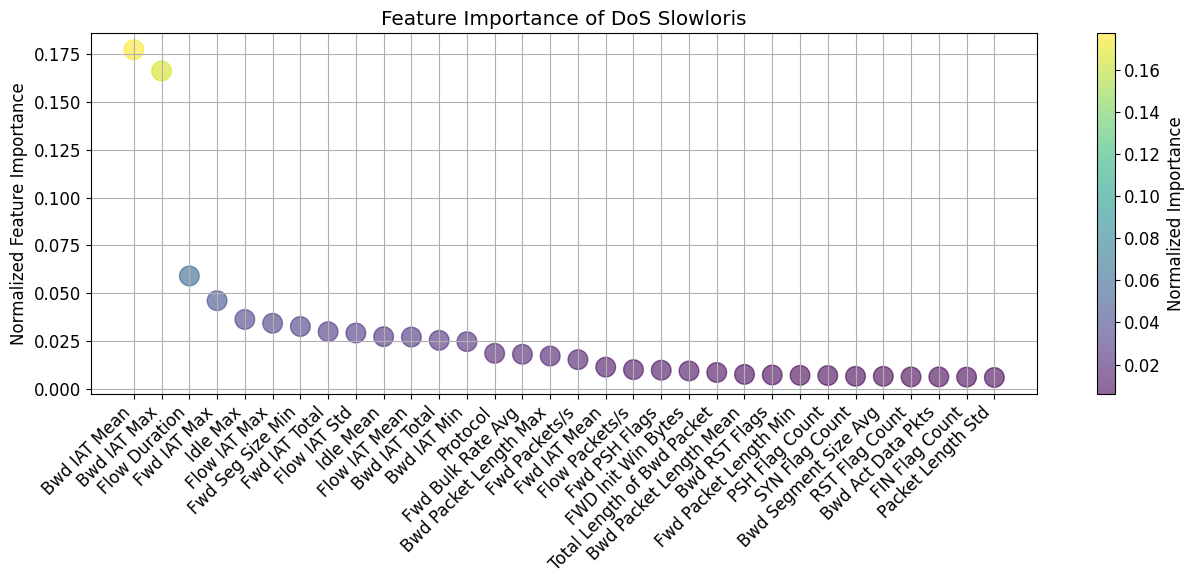

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

features = pd.DataFrame(pairs, columns=['Importance', 'Feature'])

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(13, 6))
scatter = plt.scatter(
    x=features['Feature'],
    y=features['Importance'],
    s=200,
    c=features['Importance'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance of DoS Slowloris')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
num_features_original = len(X_train_full_balanced.columns)
num_features_selected = len(fs)

print(f"Features before selection: {num_features_original}")
print(f"Features after selection: {num_features_selected}")

Features before selection: 81
Features after selection: 32


In [18]:
X_train_full_balanced_fs = X_train_full_balanced[fs]

In [19]:
balanced_train_splits_fs = []
val_splits_fs = []
for i in range(3):
    X_train_balanced, y_train_balanced = balanced_train_splits[i]
    X_val, y_val = val_splits[i]
    balanced_train_splits_fs.append((X_train_balanced[fs], y_train_balanced))
    val_splits_fs.append((X_val[fs], y_val))

# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [5]:
POST_FS_MODEL_OUTPUT = "./models_dos/postfs"

In [10]:
def cross_val_f1_binary_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]
        clf.fit(X_train_balanced_fs, y_train_balanced_fs)
        y_pred_fs = clf.predict(X_val_fs)
        results.append(f1_score(y_val_fs, y_pred_fs, average='binary'))
    return results

### DT

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_f1_binary_fs(dt)

start = time.time()
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

Training time:  11.78657054901123
Cross-Validation scores:  [0.9970617042115573, 0.9980449657869013, 0.9965770171149144]
Mean of Cross-Validation scores:  0.9972278957044577


In [41]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models_dos/postfs/dt_untuned.pkl']

In [42]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [12:37<00:00, 15.16s/trial, best loss: -0.9982018922063999]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 11}


DecisionTreeClassifier(criterion='entropy', max_depth=19, min_samples_split=11,
                       random_state=0)

In [43]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")

['./models_dos/postfs/dt_tuned.pkl']

In [12]:
dt_score = 0.9982018922063999

### RF

In [44]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_f1_binary_fs(rf)

# calculate the training time
start = time.time()
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

Training time:  21.08798050880432
Cross-Validation scores:  [1.0, 0.9990215264187867, 0.9990205680705191]
Mean of Cross-Validation scores:  0.9993473648297687


In [45]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models_dos/postfs/rf_untuned.pkl']

In [46]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 5),
    'max_depth': hp.quniform('max_depth', 5, 40, 3),
    "max_features":hp.quniform('max_features', 1, 7, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [33:03<00:00, 39.66s/trial, best loss: -0.9996736824930658]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 125}


RandomForestClassifier(criterion='entropy', max_depth=30, max_features=1,
                       min_samples_leaf=8, min_samples_split=7,
                       n_estimators=125, random_state=0)

In [47]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")

['./models_dos/postfs/rf_tuned.pkl']

In [13]:
rf_score = 0.9996736824930658

In [48]:
import gc
gc.collect()

1092

In [15]:
from sklearn.ensemble import RandomForestClassifier

# RF Single Thread
# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, n_jobs=1, **{'criterion': 'entropy', 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 125})
rf.fit(X_train_full_balanced_fs, y_train_full_balanced)

RandomForestClassifier(criterion='entropy', max_depth=30, max_features=1,
                       min_samples_leaf=8, min_samples_split=7,
                       n_estimators=125, n_jobs=1, random_state=0)

In [16]:
import joblib
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_tuned_single.pkl")

['./models_dos/postfs/rf_tuned_single.pkl']

### ET

In [49]:
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=12)
et_scores = cross_val_f1_binary_fs(et)

# calculate the training time
start = time.time()
et.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

Training time:  14.040717840194702
Cross-Validation scores:  [0.9995100440960314, 0.9990215264187867, 0.9995100440960314]
Mean of Cross-Validation scores:  0.9993472048702832


In [50]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models_dos/postfs/et_untuned.pkl']

In [51]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [30:26<00:00, 36.53s/trial, best loss: -0.9996735226118766]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 49, 'max_features': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 185}


ExtraTreesClassifier(criterion='entropy', max_depth=49, max_features=20,
                     min_samples_leaf=6, min_samples_split=6, n_estimators=185,
                     random_state=0)

In [14]:
et_score = 0.9996735226118766 # from printed best loss above

In [52]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")

['./models_dos/postfs/et_tuned.pkl']

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, n_jobs=1, **{'criterion': 'entropy', 'max_depth': 49, 'max_features': 20, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 185})
et.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_tuned_single.pkl")

['./models_dos/postfs/et_tuned_single.pkl']

In [53]:
import gc
gc.collect()

56

### XGBoost

In [54]:
import xgboost as xgb
import numpy as np

# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=12)
xg_scores = cross_val_f1_binary_fs(xg)

# calculate the training time
start = time.time()
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

Training time:  1.3783040046691895
Cross-Validation scores:  [1.0, 0.9995105237395986, 0.9975550122249389]
Mean of Cross-Validation scores:  0.9990218453215126


In [55]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models_dos/postfs/xg_untuned.pkl']

In [56]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(eval_metric='logloss', random_state=0, n_jobs=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 150, 3),
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 1),
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, **best)
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [03:16<00:00,  3.93s/trial, best loss: -0.9996736824930658]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.8030330085397716, 'max_depth': 2, 'n_estimators': 132}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.8030330085397716, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=132, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [15]:
xg_score = 0.9996736824930658

In [57]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")

['./models_dos/postfs/xg_tuned.pkl']

In [22]:
import xgboost as xgb

# Use the best parameters to train the model
xg = xgb.XGBClassifier(eval_metric='logloss', random_state=0, n_jobs=1, **{'learning_rate': 0.8030330085397716, 'max_depth': 2, 'n_estimators': 132})
xg.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_tuned_single.pkl")

['./models_dos/postfs/xg_tuned_single.pkl']

### LightGBM

In [58]:
import lightgbm as lgb
import numpy as np

# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=12)
lgbm_scores = cross_val_f1_binary_fs(lgbm)

# calculate the training time
start = time.time()
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6236
[LightGBM] [Info] Number of data points in the train set: 614602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [59]:
import joblib
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models_dos/postfs/lgbm_untuned.pkl']

In [60]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from hyperopt import hp, fmin, tpe, STATUS_OK

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6236                     
[LightGBM] [Info] Number of data points in the train set: 614602, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

LGBMClassifier(learning_rate=0.3874203284553729, max_depth=51,
               min_child_samples=48, n_estimators=72, num_leaves=27,
               random_state=0)

In [61]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")

['./models_dos/postfs/lgbm_tuned.pkl']

In [23]:
import lightgbm as lgb

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=1, **{'learning_rate': 0.3874203284553729, 'max_depth': 51, 'min_child_samples': 48, 'n_estimators': 72, 'num_leaves': 27})
lgbm.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned_single.pkl")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 308322, number of negative: 613581
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6230
[LightGBM] [Info] Number of data points in the train set: 921903, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

['./models_dos/postfs/lgbm_tuned_single.pkl']

In [16]:
lgbm_score = 0.9993473649861316

### CatBoost

In [62]:
from catboost import CatBoostClassifier
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, cat_features=['Protocol'], verbose=False)
cat_scores = cross_val_f1_binary_fs(cat)

# calculate the training time
start = time.time()
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)
end = time.time()
print('Training time: ', end - start)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

Training time:  30.99692678451538
Cross-Validation scores:  [1.0, 0.9995105237395986, 0.9980430528375733]
Mean of Cross-Validation scores:  0.999184525525724


In [63]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models_dos/postfs/cat_untuned.pkl']

In [18]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=12, **params)
    score = np.mean(cross_val_f1_binary_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], **best)
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

100%|██████████| 50/50 [1:01:48<00:00, 74.16s/trial, best loss: -0.9995103639367059] 
CatBoost: Hyperopt estimated optimum {'depth': 5, 'iterations': 800, 'learning_rate': 0.5890461989091759}


In [17]:
cat_score = 0.9995103639367059

In [19]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

['./models_dos/postfs/cat_tuned.pkl']

In [24]:
import catboost as cb

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, cat_features=['Protocol'], thread_count=1, **{'depth': 5, 'iterations': 800, 'learning_rate': 0.5890461989091759})
cat.fit(X_train_full_balanced_fs, y_train_full_balanced)

joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_tuned_single.pkl")

['./models_dos/postfs/cat_tuned_single.pkl']

## Model selection

In [25]:
import joblib
dt = joblib.load(f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")
rf = joblib.load(f"{POST_FS_MODEL_OUTPUT}/rf_tuned.pkl")
et = joblib.load(f"{POST_FS_MODEL_OUTPUT}/et_tuned.pkl")
xg = joblib.load(f"{POST_FS_MODEL_OUTPUT}/xg_tuned.pkl")
lgbm = joblib.load(f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned.pkl")
cat = joblib.load(f"{POST_FS_MODEL_OUTPUT}/cat_tuned.pkl")

In [20]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': dt_score,
    'rf': rf_score,
    'et': et_score,
    'xg': xg_score,
    'lgbm': lgbm_score,
    'cat': cat_score,

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [21]:
base_model_performance

{'dt': 0.9982018922063999,
 'rf': 0.9996736824930658,
 'et': 0.9996735226118766,
 'xg': 0.9996736824930658,
 'lgbm': 0.9993473649861316,
 'cat': 0.9995103639367059}

In [22]:
ranked_models

['rf', 'xg', 'et', 'cat', 'lgbm', 'dt']

In [23]:
top_3_models

['rf', 'xg', 'et']

In [26]:
def transform_stk3(x_val_stk):
    y_model_1 = rf.predict(x_val_stk).reshape(-1, 1)
    y_model_2 = xg.predict(x_val_stk).reshape(-1, 1)
    y_model_3 = et.predict(x_val_stk).reshape(-1, 1)
    y_proba_1 = rf.predict_proba(x_val_stk)
    y_proba_2 = xg.predict_proba(x_val_stk)
    y_proba_3 = et.predict_proba(x_val_stk)
    return np.concatenate([y_model_1, y_model_2, y_model_3] + [y_proba_1, y_proba_2, y_proba_3], axis=1)

In [27]:
def cross_val_f1_binary_stk3_fs(clf):
    results = []
    for i in range(3):
        X_train_balanced_fs, y_train_balanced_fs = balanced_train_splits_fs[i]
        X_val_fs, y_val_fs = val_splits_fs[i]

        x_train_tf = transform_stk3(X_train_balanced_fs)
        x_val_tf = transform_stk3(X_val_fs)

        clf.fit(x_train_tf, y_train_balanced_fs)
        y_pred_fs = clf.predict(x_val_tf)
        results.append(f1_score(y_val_fs, y_pred_fs, average='binary'))
    return results

In [28]:
# Ensemble method 3: hybrid stacking
import lightgbm as lgb

stk3 = lgb.LGBMClassifier(random_state=0)
stk3_scores = cross_val_f1_binary_stk3_fs(stk3)

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', stk3_scores)
print('Mean of Cross-Validation scores: ', np.mean(stk3_scores))

x_stk3 = transform_stk3(X_train_full_balanced_fs)
stk3.fit(x_stk3, y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 614602, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=0)

In [29]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/ocse_untuned_2.pkl")

['./models_dos/postfs/ocse_untuned_2.pkl']

In [30]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    score = np.mean(cross_val_f1_binary_stk3_fs(clf))
    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 3),
    'max_depth': hp.quniform('max_depth', 4, 100, 3),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 50, 3),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 3)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
stk3 = lgb.LGBMClassifier(random_state=0, n_jobs=1, **best)
stk3.fit(transform_stk3(X_train_full_balanced_fs), y_train_full_balanced)

[LightGBM] [Info] Number of positive: 205548, number of negative: 409054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326                     
[LightGBM] [Info] Number of data points in the train set: 614602, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334441 -> initscore=-0.688168
[LightGBM] [Info] Start training from score -0.688168 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

LGBMClassifier(learning_rate=0.9144448744360978, max_depth=18,
               min_child_samples=27, n_estimators=90, n_jobs=1, num_leaves=36,
               random_state=0)

In [31]:
joblib.dump(stk3, f"{POST_FS_MODEL_OUTPUT}/ocse_tuned_single.pkl")

['./models_dos/postfs/ocse_tuned_single.pkl']

# Inference Time Test

In [1]:
TRIES = 100

In [2]:
import time

# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_train_full_balanced_fs)) * 1000)
    return np.average(times)

In [3]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

In [6]:
import joblib
dt = joblib.load(f"{POST_FS_MODEL_OUTPUT}/dt_tuned.pkl")
rf = joblib.load(f"{POST_FS_MODEL_OUTPUT}/rf_tuned_single.pkl")
et = joblib.load(f"{POST_FS_MODEL_OUTPUT}/et_tuned_single.pkl")
xg = joblib.load(f"{POST_FS_MODEL_OUTPUT}/xg_tuned_single.pkl")
lgbm = joblib.load(f"{POST_FS_MODEL_OUTPUT}/lgbm_tuned_single.pkl")
cat = joblib.load(f"{POST_FS_MODEL_OUTPUT}/cat_tuned_single.pkl")
ocse = joblib.load(f"{POST_FS_MODEL_OUTPUT}/ocse_tuned_single.pkl")

In [ ]:
dos_inference_times: list[tuple] = []

# Decision Tree
dos_inference_times.append(("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[0])

# Random Forest
dos_inference_times.append(("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[1])

# Extra Trees
dos_inference_times.append(("ET", calculate_inference_time_in_ms(lambda: et.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[2])

# XGBoost
dos_inference_times.append(("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[3])

# LightGBM
dos_inference_times.append(("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_train_full_balanced_fs), TRIES)))
print(dos_inference_times[4])

# CatBoost
dos_inference_times.append(("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_train_full_balanced_fs, thread_count=1), TRIES)))
print(dos_inference_times[5])

('DT', 9.150150726218491e-05)
('RF', 0.0018603246766475065)
('ET', 0.0026297670807421663)
('XG', 0.0003311484643334342)
('LGBM', 0.0013077947227137093)
('Cat', 0.0005377028984189582)


NameError: name 'stk3' is not defined

In [21]:
# OCSE (Change based on training's top 3 models results)
def ocse_timer():
    model_1_test = et.predict(X_train_full_balanced_fs).reshape(-1, 1)
    model_2_test = lgbm.predict(X_train_full_balanced_fs).reshape(-1, 1)
    model_3_test = rf.predict(X_train_full_balanced_fs).reshape(-1, 1)

    model_1_prob_test = et.predict_proba(X_train_full_balanced_fs)
    model_2_prob_test = lgbm.predict_proba(X_train_full_balanced_fs)
    model_3_prob_test = rf.predict_proba(X_train_full_balanced_fs)

    x_test = np.concatenate([model_1_test, model_2_test, model_3_test] + [model_1_prob_test, model_2_prob_test, model_3_prob_test], axis=1)

    ocse.predict(x_test)

dos_inference_times.append(("OCSE", calculate_inference_time_in_ms(ocse_timer, TRIES)))
print(dos_inference_times[6])

KeyboardInterrupt: 

In [ ]:
dos_times = sorted(dos_inference_times, key=lambda x: x[1])
dos_times

In [ ]:
[[a, format(b, '.5f')] for a, b in dos_times]